In [1]:
import os
import os.path as osp
import json
import numpy as np
from shapely.geometry import Polygon
from dataset import resize_img, adjust_height, rotate_img, crop_img, generate_roi_mask
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.20 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [2]:
_lang_list = ['chinese', 'japanese', 'thai', 'vietnamese']
root_dir = os.environ.get('SM_CHANNEL_TRAIN', 'data')
split = 'train'
total_anno = dict(images=dict())
for nation in _lang_list:
    with open(osp.join(root_dir, '{}_receipt/ufo/{}.json'.format(nation, split)), 'r', encoding='utf-8') as f:
        anno = json.load(f)
    for im in anno['images']:
        total_anno['images'][im] = anno['images'][im]

anno = total_anno
image_fnames = sorted(anno['images'].keys())


In [3]:
def _infer_dir(fname):
    lang_indicator = fname.split('.')[1]
    if lang_indicator == 'zh':
        lang = 'chinese'
    elif lang_indicator == 'ja':
        lang = 'japanese'
    elif lang_indicator == 'th':
        lang = 'thai'
    elif lang_indicator == 'vi':
        lang = 'vietnamese'
    else:
        raise ValueError
    return osp.join(root_dir, f'{lang}_receipt', 'img', split)


In [4]:
def filter_vertices(vertices, labels, ignore_under=0, drop_under=0):
    if drop_under == 0 and ignore_under == 0:
        return vertices, labels

    new_vertices, new_labels = vertices.copy(), labels.copy()

    areas = np.array([Polygon(v.reshape((4, 2))).convex_hull.area for v in vertices])
    labels[areas < ignore_under] = 0

    if drop_under > 0:
        passed = areas >= drop_under
        new_vertices, new_labels = new_vertices[passed], new_labels[passed]

    return new_vertices, new_labels


In [5]:
ignore_under_threshold=10
drop_under_threshold=1
image_size=2048
crop_size=1024

In [6]:
%%time

idx=2
image_fname = image_fnames[idx]
image_fpath = osp.join(_infer_dir(image_fname), image_fname)

vertices, labels = [], []
for word_info in anno['images'][image_fname]['words'].values():
    num_pts = np.array(word_info['points']).shape[0]
    if num_pts > 4:
        continue
    vertices.append(np.array(word_info['points']).flatten())
    labels.append(1)
vertices, labels = np.array(vertices, dtype=np.float32), np.array(labels, dtype=np.int64)

vertices, labels = filter_vertices(
    vertices,
    labels,
    ignore_under=ignore_under_threshold,
    drop_under=drop_under_threshold
)

image = Image.open(image_fpath)
image, vertices = resize_img(image, vertices, image_size)
image, vertices = adjust_height(image, vertices)
image, vertices = rotate_img(image, vertices)
image, vertices = crop_img(image, vertices, labels, crop_size)

if image.mode != 'RGB':
    image = image.convert('RGB')
image = np.array(image)


# funcs = []
# if True:
#     funcs.append(A.ColorJitter())
# if True:
#     funcs.append(A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
# transform = A.Compose(funcs)

image = transform(image=image)['image']
word_bboxes = np.reshape(vertices, (-1, 4, 2))
roi_mask = generate_roi_mask(image, vertices, labels)


CPU times: user 342 ms, sys: 54.3 ms, total: 396 ms
Wall time: 1.67 s


In [ ]:
word_bboxes

In [8]:
vertices.shape

(71, 8)

In [13]:
vertices[0]

array([ 174.0225268 , -213.29617658,  296.61798317, -209.38560929,
        294.73984353, -155.28073554,  172.14438656, -159.19127231])

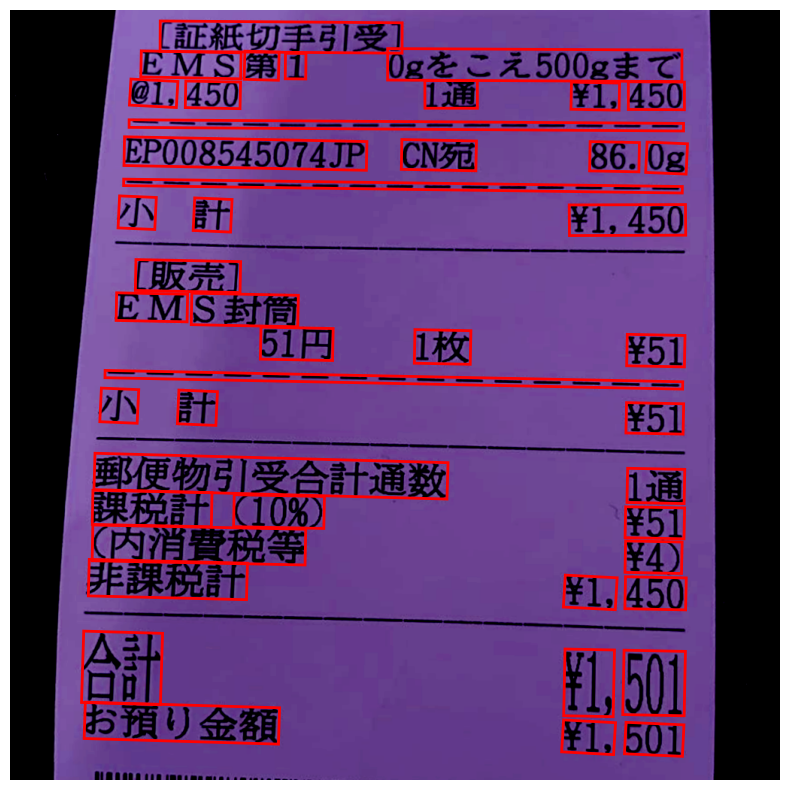

In [15]:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)

# bounding box를 시각화
for i, bbox in enumerate(vertices):
    # bbox를 (x1, y1, x2, y2, x3, y3, x4, y4) 형식에서 (4, 2) 형식으로 reshape
    points = np.array(bbox).reshape((4, 2))

    # bounding box를 닫힌 사각형 형태로 표시
    polygon = patches.Polygon(points, closed=True, edgecolor='red', linewidth=2, fill=False)
    ax.add_patch(polygon)

    # label이 있는 경우 bbox 위에 표시
    # if labels is not None:
    #     x, y = points[0]
    #     ax.text(x, y, f'Label: {labels[i]}', color='blue', fontsize=12, verticalalignment='top')

plt.axis('off')
plt.show()
